In [72]:
import pandas as pd
import geopandas as gpd
import glob
import requests
import zipfile
import os
import io
from tqdm import tqdm

In [157]:
DIR_DATA = "Z:/lab/モバイル空間統計/"
DIR_MESH = "Z:\\lab\\境界データ\\500mメッシュ\\"
DIR_POLY = "Z:\\lab\\境界データ\\japan_ver84\\japan_ver84.shp"
DIR_WEEKDAY_OUT = "Z:\\lab\\SSI2024_検証\\モバイル空間統計_WEEKDAY\\"
URL_MESH = "https://www.e-stat.go.jp/gis/statmap-search/data?dlserveyId=H&code={}&coordSys=1&format=shape&downloadType=5"
ISHIGAKI_J_CODE = "47207"
OKINAWA_PREF_CODE = "47"
NTT_TIME_LIST = ['0000', '0100', '0200', '0300', '0400', '0500', '0600', '0700', '0800', '0900', '1000', '1100', '1200', '1300', '1400', '1500', '1600', '1700', '1800', '1900', '2000', '2100', '2200', '2300']
NTT_DATE_LIST = ["20190204","20190205","20190206","20190207","20190208"]

境界データの準備

In [84]:
# meshのshpをestatからダウンロード
target_mesh_codes = ['M3622', 'M3623', 'M3624', 'M3631', 'M3724', 'M3725', 'M3823', 'M3824', 'M3831', 'M3926', 'M3927', 'M3928', 'M4027', 'M4028', 'M4128'] # hpをテキストとして，コピーし，gptで抜き出す
for c in tqdm(target_mesh_codes):
    target_mesh_code = c[1:]
    response = requests.get(URL_MESH.format(target_mesh_code))
    
    save_dir = DIR_MESH + OKINAWA_PREF_CODE +"\\"
    # ディレクトリが存在しない場合は作成
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # メモリ上でZIPファイルを解凍
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # ZIPファイル内のファイルをすべて解凍して保存先ディレクトリに展開
        z.extractall(save_dir)

100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


In [91]:
# shpファイルを読み込む
all_mesh = gpd.GeoDataFrame()
for path in tqdm(glob.glob(DIR_MESH + OKINAWA_PREF_CODE +"/*.shp")):
    all_mesh = pd.concat([all_mesh,gpd.read_file(path).to_crs(6668)])
target_poly = gpd.read_file(DIR_POLY)[["JCODE","geometry"]].query("JCODE == @ISHIGAKI_J_CODE").to_crs(6668)

100%|██████████| 15/15 [00:21<00:00,  1.41s/it]


In [ ]:
# インターセクトで，対象市区町村のデータを抽出
target_mesh = gpd.sjoin(all_mesh,target_poly,how="inner",predicate="intersects").filter(items=["KEY_CODE","JCODE","geometry"])
TARGET_MESH_IDS = target_mesh["KEY_CODE"].astype(str).to_list()

モバイル空間統計の抽出

In [159]:
# モバイル空間統計の読み込み
for time in tqdm(NTT_TIME_LIST):
    mobile_by_times = []
    for date in NTT_DATE_LIST:
        path = DIR_DATA + f"{date}/clipped_mesh_pop_{date}{time}_00003.csv.zip"
        raw_mobile = pd.read_csv(path,
                                 usecols=["date","time","area","residence","population"],
                                 dtype={"date":str,"time":str,"area":str,"residence":str,"population":int}
                                 ).query("residence == @ISHIGAKI_J_CODE").drop(columns=["residence"])
        mobile_by_times.append(target_mesh.filter(items=["KEY_CODE"]).merge(raw_mobile,how="left",left_on="KEY_CODE",right_on="area").drop(columns=["area"]))
    mobile_by_time = pd.concat(mobile_by_times,axis=0).drop(columns=["date"])
    mobile_by_time["time"] = mobile_by_time["time"].fillna(time)
    mobile_by_time["population"] = mobile_by_time["population"].fillna(0.0)
    mobile_by_time.groupby(["KEY_CODE","time"]).mean()
    mobile_by_time.to_csv(DIR_WEEKDAY_OUT+f"{time}.csv",index=False)

100%|██████████| 24/24 [01:54<00:00,  4.78s/it]


In [138]:
weekday_mean = target_mesh.filter(items=["KEY_CODE"]).merge(mobile_by_time,how="left",left_on="KEY_CODE",right_on="area").drop(columns=["area"])
weekday_mean["time"] = weekday_mean["time"].fillna(time)
weekday_mean["population"] = weekday_mean["population"].fillna(0.0)
weekday_mean.groupby(["KEY_CODE","time"],as_index=False).mean()

,KEY_CODE,time,population
0,362431911,0000,0.0
1,362431912,0000,0.0
2,362431913,0000,0.0
3,362431914,0000,0.0
4,362431923,0000,13.0
...,...,...,...
975,382375053,0000,0.0
976,382375141,0000,0.0
977,382375142,0000,0.0
978,382474043,0000,0.0


In [135]:
weekday_mean

0       0000
1       0000
2       0000
3       0000
4       0000
        ... 
1566    0000
1567    0000
1568    0000
1569    0000
1570    0000
Name: time, Length: 1571, dtype: object

In [132]:
target_mesh.filter(items=["KEY_CODE"]).merge(mobile_by_time,how="left",left_on="KEY_CODE",right_on="area").drop(columns=["area"])

,KEY_CODE,time,population
0,362431911,NaN,NaN
1,362431912,NaN,NaN
2,362431913,NaN,NaN
3,362431914,NaN,NaN
4,362431923,0000,13.0
...,...,...,...
1566,382375053,NaN,NaN
1567,382375141,NaN,NaN
1568,382375142,NaN,NaN
1569,382474043,NaN,NaN


<Axes: >

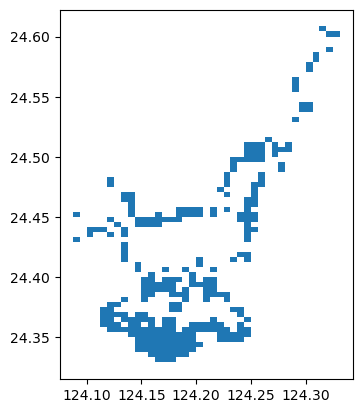

In [62]:
ishigaki_mesh.plot()

In [161]:
target_mesh.to_file("Z:\\lab\\SSI2024_検証\\47207_mesh_poly.shp")